**1.Visualize the Optimization Process**

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torch.nn.utils import parameters_to_vector, vector_to_parameters
from torch.autograd import Variable
from sklearn.decomposition import PCA
import pandas as pd
import copy
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer
import matplotlib
from matplotlib.pyplot import figure
torch.manual_seed(1)
path="/Users/mithileshbiradar/Desktop"

In [5]:
trainingdataset = torchvision.datasets.MNIST(root='./data', 
                                           train=True, 
                                           transform=transforms.ToTensor(),  
                                           download=True)

testingdataset = torchvision.datasets.MNIST(root='./data', 
                                          train=False, 
                                          transform=transforms.ToTensor())

def loadtrain(batch_size):
    loadtrain = torch.utils.data.DataLoader(dataset=trainingdataset, 
                                           batch_size = batch_size, 
                                           shuffle=True)
    return loadtrain

def loadtest(batch_size):
    loadtest = torch.utils.data.DataLoader(dataset=testingdataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)
    return loadtest
print("trainingdataset size:", len(trainingdataset),"\ntestingdataset size:", len(testingdataset))


trainingdataset size: 60000 
testingdataset size: 10000


In [6]:
class DNN(nn.Module):
    def __init__(self,):
        super(DNN, self).__init__()
        self.fc1 = nn.Linear(784, 500)
        self.fc2 = nn.Linear(500, 50)
        self.fc3 = nn.Linear(50, 10)

    def forward(self, x):
        # flatten as one dimension
        x = x.reshape(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [7]:
#train function
def trainingfunction(model,num_epochs,train_batch_size,status_interval):
    model.train()
    print('strated')
    trainingload = loadtrain(train_batch_size)
    totsteps = len(trainingload)
    trainingloss = []
    trainingepochs = []
    trainingaccuracy = []
    epoch = 0
    modelParamWgt = pd.DataFrame()
    avglossintrain = []
    avgsccintrain = []

    for epoch in range (num_epochs):
        epoch += 1
        correctn = 0
        samplesn = 0
        lossSum =0
        totalacc=0
        epoch_df = pd.DataFrame()

        for i, (images, labels) in enumerate(trainingload):  
            images, labels = Variable(images),Variable(labels)
            
            optimizer.zero_grad()
            
            # Forward pass
            prediction = model(images)

            images.requires_grad = True

            loss = loss_func(prediction, labels)
            lossSum += loss.detach().numpy()

            # Backward and optimize
            
            loss.backward()

            optimizer.step()

            _, predicted = torch.max(prediction.data, 1)
            samplesn += labels.size(0)
            correctn += (predicted == labels).sum().item()
            acc = 100.0 * correctn / samplesn
            totalacc += acc

            trainingloss.append(loss.item())
            trainingaccuracy.append(acc)
            trainingepochs.append(epoch)

            #Print Status
            if (i+1) % status_interval == 0:
                print (f'Train O/P: Epoch [{epoch}/{num_epochs}], Step [{i+1}/{totsteps}], Loss: {loss.item():.4f}',end= '\r',flush = True)
        
        #Weight Collection
        for name, parameter in model.named_parameters():
            #print(name)
            if'weight' in name:
                weights = torch.nn.utils.parameters_to_vector(parameter).detach().numpy() 
                epoch_df = pd.concat([epoch_df, pd.DataFrame(weights).T], axis = 1) 

        modelParamWgt = pd.concat([modelParamWgt, epoch_df], axis = 0)     

       
        epochLoss = lossSum/totsteps
        epochAcc = totalacc/totsteps
        #print("Train Avg loss:",trainAvgLoss)
        avglossintrain.append(epochLoss)    
        avgsccintrain.append(epochAcc)
                       
    return trainingepochs,trainingloss,trainingaccuracy,avglossintrain,avgsccintrain, modelParamWgt
def testFunction(model,loss_func,test_batch_size): 
    test_load = loadtest(test_batch_size)
    model.eval()
    with torch.no_grad():
        correctn = 0
        samplesn = 0
        testLoss = 0
        count = 0
        for images, labels in test_load:
            images, labels = Variable(images),Variable(labels)
            
            prediction = model(images)
            testLoss += loss_func(prediction,labels).item()
            # max returns (value ,index)
            _, predicted = torch.max(prediction.data, 1)
            samplesn += labels.size(0)
            correctn += (predicted == labels).sum().item()
            count += 1
    netTest_loss = testLoss/count
    netTest_acc1 = 100.0 * correctn / samplesn
    print(f'Accuracy of the network on the test images: {netTest_acc1}% & Test Loss: {netTest_loss}',end= '\r',flush = True)
    return netTest_acc1, netTest_loss

In [8]:
a=[]
tempModel = DNN()
for i in tempModel.parameters():
    a.append(torch.numel(i))
print(f'Total parameters: {np.sum(a)}')

Total parameters: 418060


In [11]:
max_epochs = 40
all_df = pd.DataFrame()
columns=["x","y","Times"]
trains={}
tests={}
trainlossess={}
testinglossess={}
trainbsize = 1000
testbsize = 1000
status_interval = 70
loss_func = nn.CrossEntropyLoss()
firstLayer = pd.DataFrame()

for count in range(8):

    j = copy.deepcopy(count)

    j = DNN()  

    print("Time: "+str(count))
    optimizer = torch.optim.Adam(j.parameters(), lr=0.0005, weight_decay=1e-4)
    model_name1 = "Times:"+str(count)  
    
    trainingepochs, trainingloss, trainingaccuracy, trainAvgLoss, avgsccintrain, modelParamWgt = trainingfunction(j, max_epochs, trainbsize, status_interval)
    testaccu, testLoss = testFunction(j, loss_func, testbsize)

    all_df = pd.concat([all_df, modelParamWgt])
    
    tests[count] = testaccu
    trainlossess[count] = trainAvgLoss
    testinglossess[count] = testLoss
    trains[count] = avgsccintrain


Time: 0
strated
Time: 1y of the network on the test images: 97.98% & Test Loss: 0.06411640271544457
strated
Time: 2y of the network on the test images: 97.93% & Test Loss: 0.06627655737102031
strated
Time: 3y of the network on the test images: 98.06% & Test Loss: 0.06368315126746893
strated
Time: 4y of the network on the test images: 98.07% & Test Loss: 0.061351175978779794
strated
Time: 5y of the network on the test images: 98.08% & Test Loss: 0.06331062112003565
strated
Time: 6y of the network on the test images: 98.03% & Test Loss: 0.06497378805652261
strated
Time: 7y of the network on the test images: 98.03% & Test Loss: 0.06344301849603654
strated


In [13]:
trainingaccuracies = []
for key,values in enumerate(trains):
    trainingaccuracies.append(trains[key])
trainLossArr = []
for key,values in enumerate(trainlossess):
    trainLossArr.append(trainlossess[key])
print(all_df)
trainingaccuracy_df = pd.DataFrame(trainingaccuracies)
trainingaccuracy_data = np.array(trainingaccuracy_df).flatten()

train_loss_df = pd.DataFrame(trainLossArr)
train_loss_data = np.array(train_loss_df).flatten()

print(f'Shape of Loss:{np.shape(train_loss_data)} & Shape of Acc: {np.shape(trainingaccuracy_data)}')
t1 = all_df
print(pd.DataFrame(t1))


             0             1             2             3             4    \
0  -4.714727e-03 -1.134554e-04  5.791001e-04  6.200147e-04  6.440798e-04   
0   7.881401e-05  4.910270e-06  2.892802e-05  2.871726e-05 -3.926260e-05   
0  -1.891263e-06 -6.694512e-08  1.185514e-06  1.315353e-06 -1.770438e-06   
0   1.985293e-07 -3.995924e-09 -2.761134e-09  2.079297e-08 -6.457041e-08   
0  -1.530548e-08  2.512699e-10 -2.331377e-09 -2.454106e-09 -3.326288e-09   
..           ...           ...           ...           ...           ...   
0   7.869780e-39  2.007676e-38 -3.786516e-39  1.399904e-39  7.400103e-40   
0   7.869780e-39  2.021270e-38 -3.786516e-39  1.399904e-39  7.400103e-40   
0   7.869780e-39  2.034508e-38 -3.786516e-39  1.399904e-39  7.400103e-40   
0   7.869780e-39  2.048665e-38 -3.786516e-39  1.399904e-39  7.400103e-40   
0   7.869780e-39  2.059937e-38 -3.786516e-39  1.399904e-39  7.400103e-40   

             5             6             7             8             9    ...  \
0   2.

In [15]:
def pcaOps(parameterdf,itrn):
    pcaoprn =  PCA(n_components=2)

    pcavalue = pcaoprn.fit_transform(parameterdf)

    itrationData = np.full((pcavalue.shape[0],1),itrn)

    pcaDf = pd.DataFrame(np.append(pcavalue,itrationData,axis=1),columns=['x','y','itrn No.'])

    return pcaDf


In [16]:
t1 = np.array(t1)
pca = PCA(n_components=2)
datanew = pca.fit_transform(t1)

epochdfval = pd.DataFrame(datanew,columns=['x','y'])

eps_each_time = [i for i in range(max_epochs)] * 8
times = np.repeat([i for i in range(8)],max_epochs)

epochdfval['Epoch']=eps_each_time
epochdfval['Iteration']=(times)
epochdfval["Acc"] = trainingaccuracy_data
epochdfval["Loss"] = train_loss_data

print(epochdfval)
epoch3Df = epochdfval.loc[(epochdfval['Epoch']+1)%3 == 0]
epoch3Df = epoch3Df.reset_index(drop=True)
print(epoch3Df)

            x          y  Epoch  Iteration        Acc      Loss
0   -2.275502   2.124579      0          0  60.212463  1.149681
1   -2.759069   2.535337      1          0  89.608041  0.346823
2   -3.115026   2.847687      2          0  91.980916  0.270765
3   -3.427784   3.114653      3          0  93.386814  0.226755
4   -3.684913   3.334760      4          0  94.595862  0.194541
..        ...        ...    ...        ...        ...       ...
315 -3.324560 -10.466729     35          7  99.696658  0.018555
316 -3.314496 -10.442114     36          7  99.739300  0.017282
317 -3.307032 -10.409479     37          7  99.756281  0.016331
318 -3.290663 -10.370434     38          7  99.813260  0.015937
319 -3.283711 -10.336446     39          7  99.785889  0.014993

[320 rows x 6 columns]
            x          y  Epoch  Iteration        Acc      Loss
0   -3.115026   2.847687      2          0  91.980916  0.270765
1   -3.899415   3.513594      5          0  95.007387  0.169950
2   -4.361348   

In [17]:
test = np.array(epoch3Df.Acc)
mv = []
for i in range(len(test)):
    mv.append(str(int(test[i])))
len(mv)

104

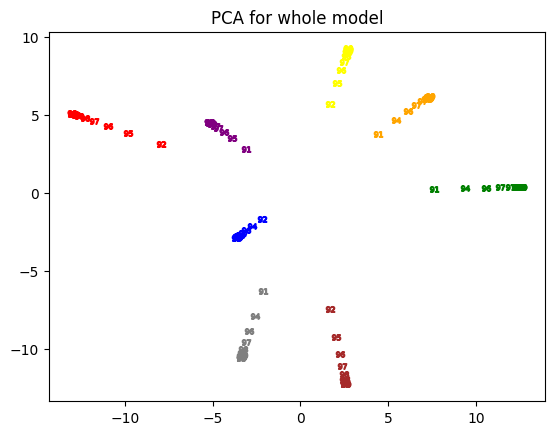

<Figure size 6600x3000 with 0 Axes>

In [19]:
cmap = ['purple','green','yellow','red','blue','brown','orange','grey']

for i in range(len(mv)):
    m = mv[i]
    c = epoch3Df['Iteration'][i]
    plt.scatter(epoch3Df['x'][i],epoch3Df['y'][i],marker=f'${m}$',color = cmap[c])
    plt.title("PCA for whole model",color="black")
    
plt.figure(figsize=[11,5],dpi=600)

plt.savefig(path+'pcamodel.pdf',
            format='jpeg',
            dpi=800,
            bbox_inches='tight')

plt.show()

            x         y  Epoch  Iteration        Acc      Loss
0    0.156891 -0.202983      0          0  60.212463  1.149681
1    0.183764 -0.274352      1          0  89.608041  0.346823
2    0.210403 -0.326015      2          0  91.980916  0.270765
3    0.222329 -0.368697      3          0  93.386814  0.226755
4    0.231355 -0.406889      4          0  94.595862  0.194541
..        ...       ...    ...        ...        ...       ...
315  0.335840  0.214339     35          7  99.696658  0.018555
316  0.332495  0.213068     36          7  99.739300  0.017282
317  0.329784  0.211425     37          7  99.756281  0.016331
318  0.324015  0.214014     38          7  99.813260  0.015937
319  0.322402  0.211027     39          7  99.785889  0.014993

[320 rows x 6 columns]


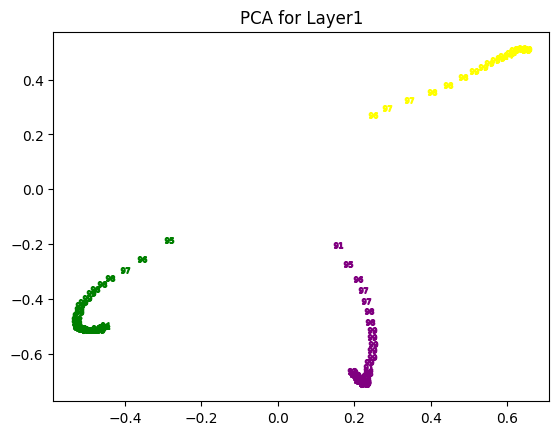

In [20]:
L1df = all_df.iloc[:,0:7840]
x2 = L1df 
x2 = np.array(x2)
pca = PCA(n_components=2)
datanew2 = pca.fit_transform(x2)
layer1Df = pd.DataFrame(datanew2,columns=['x','y'])

eps_each_time = [i for i in range(max_epochs)] * 8
times = np.repeat([i for i in range(8)],max_epochs)

layer1Df['Epoch']=eps_each_time
layer1Df['Iteration']=(times)
layer1Df["Acc"] = trainingaccuracy_data
layer1Df["Loss"] = train_loss_data
print(layer1Df)
for i in range(len(mv)):
    m = mv[i]
    c = layer1Df['Iteration'][i]
    plt.scatter(layer1Df['x'][i],layer1Df['y'][i],marker=f'${m}$',color = cmap[c])
    plt.title("PCA for Layer1",color="black")

plt.savefig(path+'pca1.pdf',
            format='jpeg',
            dpi=700,
            bbox_inches='tight')

plt.show()

**2.Visualize the Optimization Process**

In [23]:
torch.manual_seed(1) 
x = torch.unsqueeze(torch.linspace(-1, 1, 300), dim=1) 
y = x*(1/(1+torch.exp(-x)))
print('Xshape:',x.shape,"\n Yshape:",y.shape)
x, y = torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)
samplesn, n_features = x.shape

Xshape: torch.Size([300, 1]) 
 Yshape: torch.Size([300, 1])


/var/folders/71/693d7y0d06g9308xcs30vxwm0000gn/T/ipykernel_84586/3670603411.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x, y = torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)


In [37]:
class Model_1(nn.Module):
    def __init__(self,):
        super(Model_1, self).__init__()
        self.fc1 = nn.Linear(1, 500)
        self.fc2 = nn.Linear(500, 1)

    def forward(self,o):
        o = F.relu(self.fc1(o))
        x = self.fc2(o)
        return x

In [38]:
def trainingfunction(model,x,y):
    max_epoch = 2500
    trepochs,traininloss=[],[]
    not_converged = True
    epoch = 0
    gradients = []
    while not_converged:
        epoch += 1
        prediction = model(x)    
        loss = loss_func(prediction, y)     
        optimizer.zero_grad()
        loss.backward()         # backpropagation
        trepochs.append(epoch)
        traininloss.append(loss.detach().numpy())
        
        grad_all = 0.0
        for p in model.parameters():
            grad = 0.0
            if p.grad is not None:
                grad = (p.grad.cpu().data.numpy()**2).sum()
            grad_all += grad
        grad_norm = grad_all ** 0.5
    
        optimizer.step() 
        gradients.append(grad_norm)
        if epoch%100 == 0 :
            print(f'epoch: {epoch}, loss = {loss.item():.4f}, grad_norm = {grad_norm}')
        if epoch == max_epoch:
                print("Maximum Epoch Reached")
                not_converged = False
        elif (epoch > 5) and  (traininloss[-1] < 0.001):
            if abs(traininloss[-3] - traininloss[-2]) < 1.0e-05 and abs(traininloss[-2] - traininloss[-1]) < 1.0e-05:
                print("Convergeance reached for loss:",traininloss[-1])
                not_converged = False
    
    return trepochs,traininloss,prediction,grad_norm,gradients

In [40]:
torch.manual_seed(1)
mod1 = Model_1()  
optimizer = torch.optim.Adam(mod1.parameters(), lr=1e-3, weight_decay = 1e-4)
loss_func = torch.nn.MSELoss()

a=[]
for i in mod1.parameters():
    a.append(torch.numel(i))
print('Total parameters :', np.sum(a),)
M1epoch_arr,M1loss_arr,M1prediction,M1grad_norm,M1gradArr = trainingfunction(mod1,x,y)

Total parameters : 1501
Convergeance reached for loss: 3.966247e-05


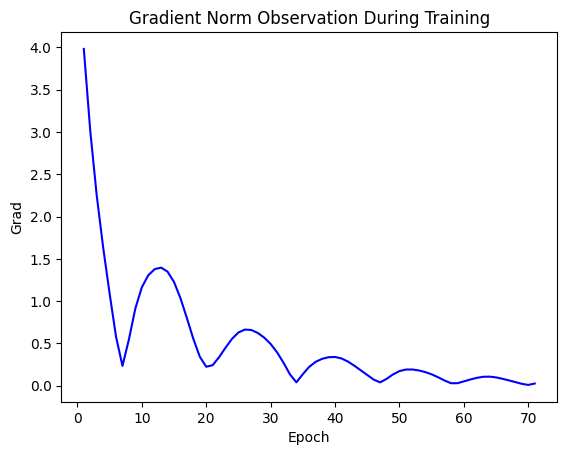

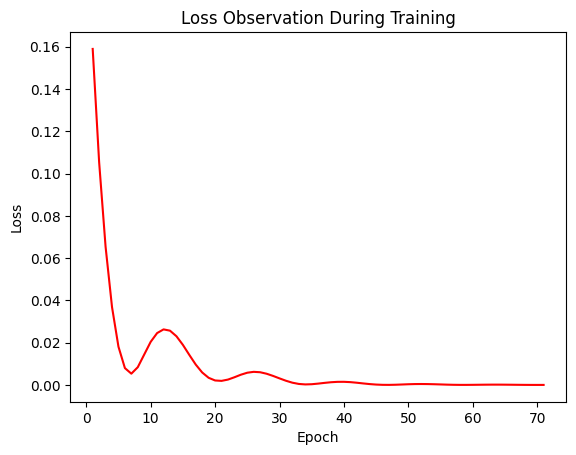

In [41]:
#plot 1
plt.plot(M1epoch_arr,M1gradArr,color="blue")
plt.title('Gradient Norm Observation During Training')
plt.xlabel("Epoch")
plt.ylabel("Grad")
plt.savefig(path+'/GradientNorm.pdf',
            dpi=700,
            bbox_inches='tight')
plt.show()
#plot 2
plt.plot(M1epoch_arr,M1loss_arr,color="Red")
plt.title('Loss Observation During Training')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.savefig(path+'/Loss.pdf',
            dpi=700,
            bbox_inches='tight')
plt.show()

3.What Happened When Gradient is Almost Zero

In [43]:
!pip install autograd_lib
from torch.optim import lr_scheduler
import torch.nn.functional as F
import numpy as np
from collections import defaultdict
from autograd_lib import autograd_lib
from torch.utils.data import DataLoader, TensorDataset

  Using cached fsspec-2024.9.0-py3-none-any.whl.metadata (11 kB)
  Using cached sympy-1.13.1-py3-none-any.whl.metadata (12 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 12.3 MB/s eta 0:00:00
Using cached fsspec-2024.9.0-py3-none-any.whl (179 kB)
Using cached sympy-1.13.1-py3-none-any.whl (6.2 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 869.2/869.2 kB 12.3 MB/s eta 0:00:00
  Attempting uninstall: sympy
    Found existing installation: sympy 1.13.2
    Uninstalling sympy-1.13.2:
      Successfully uninstalled sympy-1.13.2


In [44]:
Y_func = lambda x: x * (1 / (1 + torch.exp(-x)))
num_of_rows = 400
X= torch.unsqueeze(torch.linspace(-1,1,num_of_rows),dim=1)
Y = Y_func(X)
dataset = TensorDataset(X,Y)
data_loader = DataLoader(dataset,1,shuffle=True)

In [46]:
class regressor(nn.Module):
    def __init__(self, num_hidden=128):
        super().__init__()
        self.regressor = nn.Sequential(
            nn.Linear(1, num_hidden),
            nn.ReLU(),
            nn.Linear(num_hidden, 1)
        )

    def forward(self, x):
        x = self.regressor(x)
        return x
    
    
    
    def trainstep(self, batch,loss_fn):
        inputs, targets = batch 
        out = self(inputs)                 # Generate predictions
        loss = loss_fn(out, targets)    # Calculate loss
        return loss
    
    def validnstep(self, batch,loss_fn):
        inputs, targets = batch 
        out = self(inputs)                 # Generate predictions
        loss = loss_fn(out, targets)    # Calculate loss
        return {'val_loss': loss.detach()}
    
    def validnepoch(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        return {'val_loss': epoch_loss.item()}
    
    def trainingstep(self, batch,loss_fn):
        inputs, targets = batch 
        out = self(inputs)                 # Generate predictions
        loss = loss_fn(out, targets)    # Calculate loss
        return {'train_loss': loss.detach()}
    
    def trainendepoch(self, outputs):
        batch_losses = [x['train_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        return {'train_loss': epoch_loss.item()}
    
    
    def epochend(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}".format(epoch, result['val_loss']))
    
    

In [88]:
def grdientnorm(model, criterion, train, target):
    model.train()
    model.zero_grad()
    output = model(train)  # Ensure the model and input tensors are on the CPU
    loss = criterion(output, target)
    loss.backward() 

    grads = []
    for p in model.regressor.children():
        if isinstance(p, nn.Linear):
            param_norm = p.weight.grad.norm(2).item()  # Ensure gradients are calculated on CPU
            grads.append(param_norm)

    grad_mean = np.mean(grads) 

    return grad_mean

def activationsave(layer, A, _):
    actvn[layer] = A.cpu()  # Ensure activations are stored on CPU

def hesscomp(layer, _, B):
    A = actvn[layer].cpu()  # Move activation to CPU
    BA = torch.einsum('nl,ni->nli', B.cpu(), A)  # Ensure the tensor operations happen on the CPU
    hess[layer] += torch.einsum('nli,nkj->likj', BA, BA)

def minration(model, criterion, train, target):
    model.zero_grad()
    
    with autograd_lib.module_hook(activationsave):
        output = model(train)  # Ensure the model is on the CPU
        loss = criterion(output, target)

    with autograd_lib.module_hook(hesscomp):
        autograd_lib.backward_hessian(output, loss='LeastSquares')

    layer_hess = list(hess.values())
    minimum_ratio = []

    for h in layer_hess:
        size = h.shape[0] * h.shape[1]
        h = h.reshape(size, size)
        h_eig, _ = torch.linalg.eigh(h.cpu(), UPLO='U')
  # Move Hessian to CPU for eigenvalue computation
        num_greater = torch.sum(h_eig > 0).item()
        minimum_ratio.append(num_greater / len(h_eig))

    ratio_mean = np.mean(minimum_ratio) 

    return ratio_mean


In [89]:
def normminration(model,criterion):

    gradient_norm = grdientnorm(model, criterion, X, Y)
    minimum_ratio = minration(model, criterion, X, Y)

    print('gradient norm: {}, minimum ratio: {}'.format(gradient_norm, minimum_ratio))
    result = {}
    result["grad_norm"] = gradient_norm
    result["ratio"] = minimum_ratio
    
    return result

In [90]:
def eval(model,loss_fn, val_loader):
    outputs = [model.validnstep(batch,loss_fn) for batch in val_loader]
    return model.validnepoch(outputs)

def eval2(model,loss_fn, loadtrain):
    outputs = [model.trainingstep(batch,loss_fn) for batch in loadtrain]
    return model.trainendepoch(outputs)

def gradnorm(model):
    grad_all=0.0
    grad =0
    
    for p in model.parameters():
        if p.grad is not None:
            grad = (p.grad.cpu().data.numpy()**2).sum()
            
        grad_all+=grad
        
    grad_norm=grad_all ** 0.5
    return grad_norm


def fitting(epochs, lr, model, data_loader, criterion,opt_func):
    prev = []
    comparelossepoch =1000.0
    gradperepoch={}
    
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        optimizer.zero_grad()
        pdctn = model(X)
        loss = criterion(pdctn, Y)
        loss.backward()
        gradperepoch[epoch] = normminration(model,criterion)
        optimizer.step() 
        optimizer.zero_grad()
        result = eval(model,criterion, data_loader)
        model.epochend(epoch, result)
        prev.append(result)
        if epoch == 900:
            comparelossepoch= result["val_loss"]
    return prev,gradperepoch,model

In [91]:
rows_n = 400
lr = 0.0005
lrgamma = 0.1 
weight_decay = 1e-4
criterion = nn.MSELoss()
optimizer = torch.optim.Adam
num_epochs =2000
criterionn = "MSE_LOSS"
optimiser = "ADAMopt"
filename = criterionn+ optimiser+".png"
gradnam = "grad_name.png"
result_folder = "result/"

In [92]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam
num_epochs =2000
criterionn = "MSE_LOSS_"
optimiser = "ADAM_opt"
inputsize=1
outputsize=1
model= regressor()

In [93]:
autograd_lib.register(model)
actvn = defaultdict(int)
hess = defaultdict(float)
           

In [94]:
result3_1 = eval(model,criterion,data_loader)


In [95]:
filename = criterionn+ optimiser+".png"

In [96]:
train,target = X,Y

In [97]:
class Model_1(torch.nn.Module):
    def __init__(self,):
        super(Model_1, self).__init__()
        self.fc1 = torch.nn.Linear(1, 5)
        self.fc2 = torch.nn.Linear(5, 10)
        self.fc3 = torch.nn.Linear (10, 10)
        self.fc4 = torch.nn.Linear (10, 10)
        self.fc5 = torch.nn.Linear (10, 10)
        self.fc6 = torch.nn.Linear (10, 10)
        self.fc7 = torch.nn.Linear (10,5)
        self.predict = torch.nn.Linear(5, 1) 
        
    def forward(self, x):
        x = F.leaky_relu(self.hidden1(x))  
        x = F.leaky_relu(self.hidden2(x))
        x = F.leaky_relu(self.hidden3(x))
        x = F.leaky_relu(self.hidden4(x))
        x = F.leaky_relu(self.hidden5(x))
        x = F.leaky_relu(self.hidden6(x))
        x = F.leaky_relu(self.hidden7(x))
        x = self.predict(x)  
        return x

model_1 = Model_1()


In [98]:
history_1,grad_norm_1,model  = fitting(num_epochs, lr, model, data_loader, criterion,optimizer)

gradient norm: 2.1820084489881992, minimum ratio: 0.66796875
Epoch [0], val_loss: 0.1850
gradient norm: 2.0640943720936775, minimum ratio: 0.6640625
Epoch [1], val_loss: 0.1691
gradient norm: 1.9468918479979038, minimum ratio: 0.6875
Epoch [2], val_loss: 0.1542
gradient norm: 1.830328144133091, minimum ratio: 0.6640625
Epoch [3], val_loss: 0.1403
gradient norm: 1.7146074511110783, minimum ratio: 0.67578125
Epoch [4], val_loss: 0.1275
gradient norm: 1.5998663119971752, minimum ratio: 0.69921875
Epoch [5], val_loss: 0.1157
gradient norm: 1.4863459579646587, minimum ratio: 0.69921875
Epoch [6], val_loss: 0.1050
gradient norm: 1.3743628598749638, minimum ratio: 0.6875
Epoch [7], val_loss: 0.0954
gradient norm: 1.2642801888287067, minimum ratio: 0.66796875
Epoch [8], val_loss: 0.0868
gradient norm: 1.1566102840006351, minimum ratio: 0.68359375
Epoch [9], val_loss: 0.0793
gradient norm: 1.0520620048046112, minimum ratio: 0.69140625
Epoch [10], val_loss: 0.0728
gradient norm: 0.95166838541626

In [99]:
grad_norm_1

{0: {'grad_norm': 2.1820084489881992, 'ratio': 0.66796875},
 1: {'grad_norm': 2.0640943720936775, 'ratio': 0.6640625},
 2: {'grad_norm': 1.9468918479979038, 'ratio': 0.6875},
 3: {'grad_norm': 1.830328144133091, 'ratio': 0.6640625},
 4: {'grad_norm': 1.7146074511110783, 'ratio': 0.67578125},
 5: {'grad_norm': 1.5998663119971752, 'ratio': 0.69921875},
 6: {'grad_norm': 1.4863459579646587, 'ratio': 0.69921875},
 7: {'grad_norm': 1.3743628598749638, 'ratio': 0.6875},
 8: {'grad_norm': 1.2642801888287067, 'ratio': 0.66796875},
 9: {'grad_norm': 1.1566102840006351, 'ratio': 0.68359375},
 10: {'grad_norm': 1.0520620048046112, 'ratio': 0.69140625},
 11: {'grad_norm': 0.9516683854162693, 'ratio': 0.6953125},
 12: {'grad_norm': 0.8569561801850796, 'ratio': 0.6953125},
 13: {'grad_norm': 0.7701206691563129, 'ratio': 0.703125},
 14: {'grad_norm': 0.6942512094974518, 'ratio': 0.6953125},
 15: {'grad_norm': 0.6336589343845844, 'ratio': 0.6875},
 16: {'grad_norm': 0.5933703072369099, 'ratio': 0.6757

In [101]:
lossvalue1 = [r['val_loss'] for r in history_1]

In [102]:
len(lossvalue1)

2000

In [106]:
minrationeps = [i['ratio'] for i in grad_norm_1.values()]

FileNotFoundError: [Errno 2] No such file or directory: '/Users/mithileshbiradar/Desktop/Users/mithileshbiradar/Desktop/2.pdf'

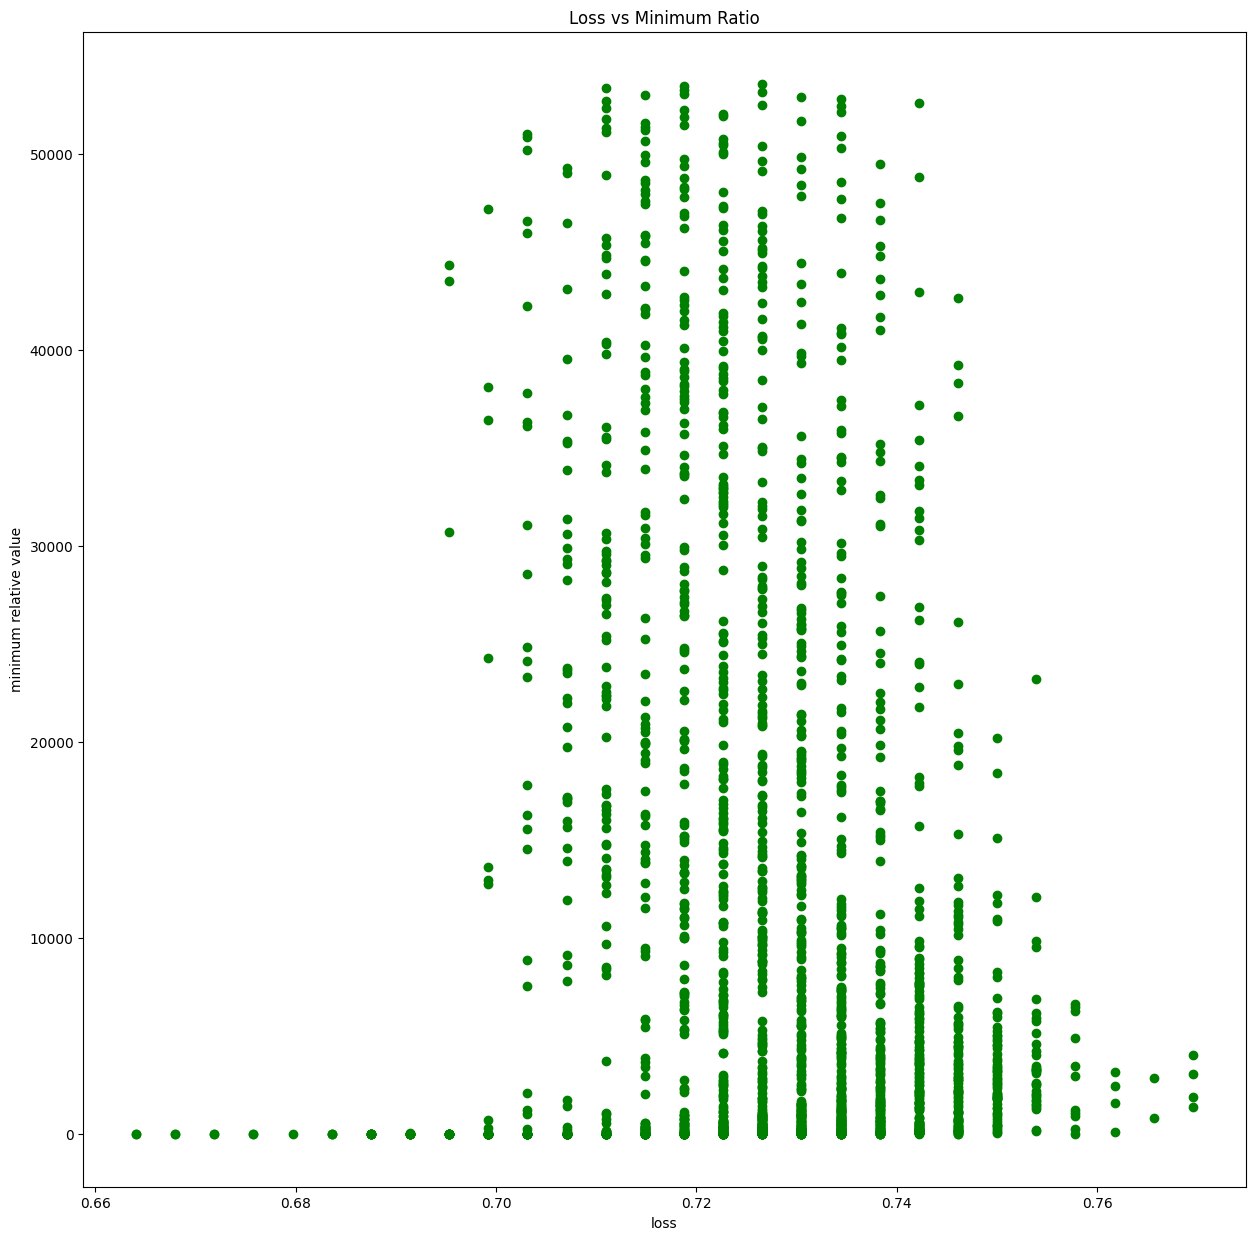

In [107]:
plt.figure(figsize=(15,15))
plt.scatter(minrationeps,lossvalue1,color = 'green')
plt.xlabel('loss')
plt.ylabel('minimum relative value')
plt.title('Loss vs Minimum Ratio')
plt.plot()
#plt.savefig(path+'/Users/mithileshbiradar/Desktop/2.pdf',
            dpi=900,
            bbox_inches='tight')
plt.savefig("minrationloss.png")